# Scraping Data from Deutscher Wetterdienst (DWD)

Since 2017, _Deutscher Wetterdienst_ (German Meteorological Service) publishes a lot of its measurements and data publicly available to its [Open Data Server](https://opendata.dwd.de/). An easy access through an API is currently not available, but instead we can browse the server directory tree where tons of data are stored as zip files.

The published data contains weather forecasts from various models, storm warnings, historical climate data and much more. Climate data is published in the directory [/climate_environment/CDC/](https://opendata.dwd.de/climate_environment/CDC/).

The data we are going to have a look at are the **hourly air temperature and humidity measurements at DWD stations in Germany**. They are stored under [this](https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/hourly/air_temperature/) URL. There exist two folders: `recent` and `historical`. _Recent_ data contains all measurements for the last 500 days until yesterday, and _historical_ data contains all available measurements until the end of the last year (some of which are dating back until the 19th century!). Note that most of the _historical_ data has undergone more steps in the quality control procedure than _recent_ data.

Each zip file on the server corresponds to the measurements of _one_ weather station. Inside a zip file, there is a text file called `produkt_...`, as well as several `Metadaten_...` text/html files. The product file contains the following information:

STATIONS_ID | MESS_DATUM | QN_9 | TT_TU | RF_TU
:---:|:---:|:---:|:---:|:---:
station id | datetime of the measurement | quality level | temperature | relative humidity
... | ... | ... | ... | ...

The meta data files contain information regarding measurement devices and methods, changes in position etc. For the sake of simplicity, I will ignore those information for now.

Additionally, for each product (i.e. hourly temperature recent/historical) the DWD provides the [list of stations](https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/hourly/air_temperature/recent/TU_Stundenwerte_Beschreibung_Stationen.txt)
involved in creating this product. Through the stations list we can associate temperature measurements with locations in Germany.
The stations list looks like this:

Stations_id | von_datum | bis_datum | Stationshoehe | geoBreite | geoLaenge | Stationsname | Bundesland
:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:
station id | start date | end date | altitude | latitude | longitude | station name | state
... | ... | ... | ... | ... | ... | ... | ...

At the end, we will have a list of 608 weather stations and their locations, as well as the history of the hourly temperature & humidity measurements of these stations.

In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from zipfile import ZipFile
import os
from pathlib import Path
import datetime
import shutil

In [2]:
DIR_base = Path.cwd().parent
DIR_data = Path.joinpath(DIR_base, "data")

DIR_raw = Path.joinpath(DIR_data, "raw")
DIR_cleaned = Path.joinpath(DIR_data, "cleaned")
DIR_processed = Path.joinpath(DIR_data, "processed")

DIR_raw_hist = Path.joinpath(DIR_raw, "hourly_temp_hist")
DIR_raw_rec = Path.joinpath(DIR_raw, "hourly_temp_rec")


# TODO: add directory check

In [3]:
URL_hourly_recent = "https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/hourly/air_temperature/recent/"
URL_hourly_historical = "https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/hourly/air_temperature/historical/"

URL_stations_recent = URL_hourly_recent + "TU_Stundenwerte_Beschreibung_Stationen.txt"
URL_stations_historical = URL_hourly_historical + "TU_Stundenwerte_Beschreibung_Stationen.txt"

## 1. Download Data
### Load the list of weather stations
The list of weather stations contains information about all the stations that provided measurements for the product _hourly temperature_. There exist own files for _recent_ and for _historical_ measurements, but they turned out to be identical.

In [4]:
def parse_weather_station_info(text):
    text = text.splitlines()
    data = []
    for line in text[2:]:
        e = line.split()
        station_id = e.pop(0)
        start_date = e.pop(0)
        end_date = e.pop(0)
        altitude = e.pop(0)
        latitude = e.pop(0)
        longitude = e.pop(0)
        state = e.pop(-1)
        station_name = " ".join(e)

        row = [station_id, start_date, end_date, altitude, latitude, longitude, station_name, state]
        data.append(row)

    columns = ["station_id", "start_date", "end_date", "altitude", "latitude", "longitude", "name", "state"]
    df = pd.DataFrame(data, columns=columns)
    
    # convert columns to numeric 
    df = df.apply(pd.to_numeric, errors="ignore")
    
    # convert dates into datetime objects
    df[["start_date", "end_date"]] = df[["start_date", "end_date"]].apply(pd.to_datetime, format="%Y%m%d")
    
    return df



# historical data
req = requests.get(URL_stations_historical)
text = req.text
stations_hist = parse_weather_station_info(text)
stations_hist.to_csv(Path.joinpath(DIR_raw, "stations_hourly_temp_hist.csv"))
stations_hist.to_pickle(Path.joinpath(DIR_processed, "stations_hourly_temp_hist.pkl"))

# recent data
req = requests.get(URL_stations_recent)
text = req.text
stations_rec = parse_weather_station_info(text)
stations_rec.to_csv(Path.joinpath(DIR_raw, "stations_hourly_temp_rec.csv"))
stations_rec.to_pickle(Path.joinpath(DIR_processed, "stations_hourly_temp_rec.pkl"))
stations_rec

,station_id,start_date,end_date,altitude,latitude,longitude,name,state
0,3,1950-04-01,2011-03-31,202,50.7827,6.0941,Aachen,Nordrhein-Westfalen
1,44,2007-04-01,2020-03-28,44,52.9336,8.2370,Großenkneten,Niedersachsen
2,52,1976-01-01,1988-01-01,46,53.6623,10.1990,Ahrensburg-Wulfsdorf,Schleswig-Holstein
3,71,2009-12-01,2020-01-02,759,48.2156,8.9784,Albstadt-Badkap,Baden-Württemberg
4,73,2007-04-01,2020-03-28,340,48.6159,13.0506,Aldersbach-Kriestorf,Bayern
...,...,...,...,...,...,...,...,...
653,14138,2009-09-15,2015-12-31,73,52.1655,14.1224,Falkenberg (Grenzschichtmessfeld),Brandenburg
654,15000,2011-04-01,2020-03-28,231,50.7983,6.0244,Aachen-Orsbach,Nordrhein-Westfalen
655,15207,2013-11-01,2020-03-28,317,51.2835,9.3590,Schauenburg-Elgershausen,Hessen
656,15444,2014-09-01,2020-03-28,593,48.4418,9.9216,Ulm-Mähringen,Baden-Württemberg


### Scrape all zip links that are available

In [5]:
def scrape_product_links(soup):
    anchors = soup.find_all("a")
    links = []
    
    for a in anchors:
        ref = a.get("href")
        if ref.startswith("stundenwerte_TU_") and ref.endswith(".zip"):
            links.append(ref)
    return links


# historical
req = requests.get(URL_hourly_historical)
soup = BeautifulSoup(req.content, "html.parser")
historical_urls = scrape_product_links(soup)


# recent
req = requests.get(URL_hourly_recent)
soup = BeautifulSoup(req.content, "html.parser")
recent_urls = scrape_product_links(soup)
  

### Download all zip files

In [6]:
def download_all_product_files(DIR_source, file_urls, DIR_destination):
    total = len(file_urls)
    print(f"Downloading {total} files to {DIR_destination}")
    
    for i, url in enumerate(file_urls, start=1):
        req = requests.get(DIR_source + url)

        filename = Path.joinpath(DIR_destination, url)
        filename.write_bytes(req.content)
            
        # unzip the file and only keep the extracted content
        with ZipFile(filename, "r") as zippy:
            dirname = Path.joinpath(DIR_destination, url[:-4])
            if os.path.isdir(dirname):
                shutil.rmtree(dirname)
            try:
                #os.mkdir(dirname)
                dirname.mkdir()
                zippy.extractall(dirname)
                os.remove(filename)
            except Exception as e:
                print(e)
        
        if i % 50 == 0 or i == total:
            print("%d of %d files downloaded" % (i , total))
            
            
# recent data
download_all_product_files(URL_hourly_historical, historical_urls, DIR_raw_hist) 

# recent data
download_all_product_files(URL_hourly_recent, recent_urls, DIR_raw_rec)

50 of 618 files downloaded
100 of 618 files downloaded
150 of 618 files downloaded
200 of 618 files downloaded
250 of 618 files downloaded
300 of 618 files downloaded
350 of 618 files downloaded
400 of 618 files downloaded
450 of 618 files downloaded
500 of 618 files downloaded
550 of 618 files downloaded
600 of 618 files downloaded
618 of 618 files downloaded
50 of 508 files downloaded
100 of 508 files downloaded
150 of 508 files downloaded
200 of 508 files downloaded
250 of 508 files downloaded
300 of 508 files downloaded
350 of 508 files downloaded
400 of 508 files downloaded
450 of 508 files downloaded
500 of 508 files downloaded
508 of 508 files downloaded


## 2. Data Extraction

Now, for every available weather station there exists a folder containing measurement as well as meta data about the corresponding station. We want to extract the temperature und humidity data from all those folders.

### Get all directories that were downloaded

In [6]:
def get_directories(path, prefix, suffix):
    dir_list = []

    dir_iter = os.scandir(path)
    for i in dir_iter:
        if i.is_dir():
            name = i.name
            if name.startswith(prefix) and name.endswith(suffix):
                #dir_list.append(name + "/")
                dir_list.append(Path(name))
                
    return dir_list



                
                
recent_folders = get_directories(DIR_raw_rec, "stundenwerte_", "_akt")
historical_folders = get_directories(DIR_raw_hist, "stundenwerte_", "_hist")
recent_folders

[PosixPath('stundenwerte_TU_03621_akt'),
 PosixPath('stundenwerte_TU_04651_akt'),
 PosixPath('stundenwerte_TU_01411_akt'),
 PosixPath('stundenwerte_TU_05516_akt'),
 PosixPath('stundenwerte_TU_01420_akt'),
 PosixPath('stundenwerte_TU_03631_akt'),
 PosixPath('stundenwerte_TU_05562_akt'),
 PosixPath('stundenwerte_TU_04887_akt'),
 PosixPath('stundenwerte_TU_02437_akt'),
 PosixPath('stundenwerte_TU_03287_akt'),
 PosixPath('stundenwerte_TU_02014_akt'),
 PosixPath('stundenwerte_TU_07075_akt'),
 PosixPath('stundenwerte_TU_07431_akt'),
 PosixPath('stundenwerte_TU_00222_akt'),
 PosixPath('stundenwerte_TU_07374_akt'),
 PosixPath('stundenwerte_TU_01078_akt'),
 PosixPath('stundenwerte_TU_06346_akt'),
 PosixPath('stundenwerte_TU_02985_akt'),
 PosixPath('stundenwerte_TU_02039_akt'),
 PosixPath('stundenwerte_TU_00154_akt'),
 PosixPath('stundenwerte_TU_02638_akt'),
 PosixPath('stundenwerte_TU_04548_akt'),
 PosixPath('stundenwerte_TU_05097_akt'),
 PosixPath('stundenwerte_TU_00257_akt'),
 PosixPath('stun

### Product file data extraction
Extract the data provided in one product file.

In [9]:
# get all files that were contained in the zip and find the product file
def get_files(path, prefix, suffix, exactly_one=False):
    file_list = []

    dir_iter = os.scandir(path)
    for i in dir_iter:
        if i.is_file():
            name = i.name
            if name.startswith(prefix) and name.endswith(suffix):
                file_list.append(Path(name))
    
    if exactly_one is True:
        if len(file_list) == 1:
            return file_list[0]
        elif len(file_list) > 1:
            raise Exception("There seem to exist two product files for the same station!")
        else:
            raise Exception("No product file found!")
    else:
        return file_list


# extract the data from the text file
def product_file_to_dataframe(file_path):
    #text = None
    #with open(file_path, "r") as file:
        #text = file.read().splitlines()
    text = file_path.read_text()
    text = text.splitlines()
    
    data = []
    for line in text[1:]:
        row = line.split(";")
        values = [value.strip() for value in row]
        values.pop()
        data.append(values)

    colnames = ["station_id", "date", "quality", "temperature", "humidity"]
    df = pd.DataFrame(data, columns=colnames)
    return df



In [10]:
# test for one file
dirname = Path.joinpath(DIR_raw_rec, "stundenwerte_TU_01612_akt")
product_name = get_files(dirname, "produkt_tu_stunde_", ".txt", exactly_one=True)


product_path = Path.joinpath(dirname, product_name)
df = product_file_to_dataframe(product_path)
df

,station_id,date,quality,temperature,humidity
0,1612,2018092600,3,2.9,88.0
1,1612,2018092601,3,3.3,83.0
2,1612,2018092602,3,3.2,82.0
3,1612,2018092603,3,2.8,83.0
4,1612,2018092604,3,1.7,88.0
...,...,...,...,...,...
13195,1612,2020032819,1,8.6,47.0
13196,1612,2020032820,1,8.1,52.0
13197,1612,2020032821,1,7.0,58.0
13198,1612,2020032822,1,6.2,62.0


### Iterate over all downloaded directories and collect the data

In [11]:
def directories_to_dataframe(DIR_root, dir_list):
    frames = []
    for folder_name in dir_list:
        path = Path.joinpath(DIR_root, folder_name)
        # find product file name
        product_file = get_files(path, "produkt_tu_stunde_", ".txt", exactly_one=True)
        product_file = Path(path, product_file)
        # extract the data from this file
        df = product_file_to_dataframe(product_file)

        frames.append(df)

    # concatenate all the frames into one frame
    return pd.concat(frames)

df_rec = directories_to_dataframe(DIR_raw_rec, recent_folders)
df_hist = directories_to_dataframe(DIR_raw_hist, historical_folders)
df_hist

,station_id,date,quality,temperature,humidity
0,131,2004110101,10,9.4,100.0
1,131,2004110102,10,9.3,100.0
2,131,2004110103,10,9.3,100.0
3,131,2004110104,10,9.1,100.0
4,131,2004110105,10,8.9,100.0
...,...,...,...,...,...
307989,554,2006022720,3,1.9,87.0
307990,554,2006022721,3,1.8,88.0
307991,554,2006022722,3,0.8,94.0
307992,554,2006022723,3,0.5,96.0


## 3. Data Cleaning
- convert columns into numerical values
- convert date column into datetime format
- remove error entries
- merge recent and historical data into one dataframe

In [12]:
def clean_data(df):
    df = df.apply(pd.to_numeric)
    df["date"] = pd.to_datetime(df["date"], format="%Y%m%d%H")

    # -999 = missing data
    df.loc[df["temperature"] == -999, "temperature"] = float("NaN")
    df.loc[df["humidity"] == -999, "humidity"] = float("NaN")
    return df

df_r = clean_data(df_rec)
df_h = clean_data(df_hist)

In [18]:
df_r

,station_id,date,quality,temperature,humidity
0,3621,2018-09-26 00:00:00,3,1.6,90.0
1,3621,2018-09-26 01:00:00,3,1.1,92.0
2,3621,2018-09-26 02:00:00,3,0.7,93.0
3,3621,2018-09-26 03:00:00,3,0.3,94.0
4,3621,2018-09-26 04:00:00,3,0.7,93.0
...,...,...,...,...,...
13195,161,2020-03-28 19:00:00,1,11.8,40.0
13196,161,2020-03-28 20:00:00,1,11.0,44.0
13197,161,2020-03-28 21:00:00,1,9.8,52.0
13198,161,2020-03-28 22:00:00,1,8.4,62.0


### Merge recent and historical data
If data overlaps, the data with the highest quality level should be kept.

In [7]:
# stack recent and historical dataframe
df = pd.concat([df_h, df_r], ignore_index=True)
# sort duplicate rows descending by quality
df.sort_values(by=["station_id", "date", "quality"], ascending=False, inplace=True)
# drop duplicate rows, keeping the first
df.drop_duplicates(["station_id", "date"], keep='first', inplace=True)

### Checkoint
Save the cleaned data as csv and pickle.

In [8]:
# recent
#df_r.to_csv(Path.joinpath(DIR_cleaned, "hourly_temp_rec.csv"), index=False)
#df_r.to_pickle(Path.joinpath(DIR_cleaned, "hourly_temp_rec.pkl"))

# historical
#df_h.to_csv(Path.joinpath(DIR_cleaned, "hourly_temp_hist.csv"), index=False)
#df_h.to_pickle(Path.joinpath(DIR_cleaned, "hourly_temp_hist.pkl"))

# combined
df.to_csv(Path.joinpath(DIR_cleaned, "hourly_temp.csv"), index=False)
df.to_pickle(Path.joinpath(DIR_cleaned, "hourly_temp.pkl"))

In [9]:
# reload data
df_r = pd.read_pickle(Path.joinpath(DIR_cleaned, "hourly_temp_rec.pkl"))
df_h = pd.read_pickle(Path.joinpath(DIR_cleaned, "hourly_temp_hist.pkl"))
df = pd.read_pickle(Path.joinpath(DIR_cleaned, "hourly_temp.pkl")) 

## 4. Summarize Data

In [14]:
# group by year
summary_all = df.groupby(pd.Grouper(key='date', freq='Y')).describe()
# group by station and by year
summary_stations = df.groupby([df["station_id"], pd.Grouper(key='date', freq='Y')]).describe()

In [15]:
summary_stations

quality                                               \
                        count      mean       std  min  25%  50%  75%  max   
station_id date                                                              
3          1950-12-31  6599.0  5.000000  0.000000  5.0  5.0  5.0  5.0  5.0   
           1951-12-31  8760.0  5.000000  0.000000  5.0  5.0  5.0  5.0  5.0   
           1952-12-31  8784.0  5.000000  0.000000  5.0  5.0  5.0  5.0  5.0   
           1953-12-31  8760.0  5.000000  0.000000  5.0  5.0  5.0  5.0  5.0   
           1954-12-31  8760.0  5.000000  0.000000  5.0  5.0  5.0  5.0  5.0   
...                       ...       ...       ...  ...  ...  ...  ...  ...   
15555      2016-12-31  5880.0  3.000000  0.000000  3.0  3.0  3.0  3.0  3.0   
           2017-12-31  8760.0  3.000000  0.000000  3.0  3.0  3.0  3.0  3.0   
           2018-12-31  8760.0  3.000000  0.000000  3.0  3.0  3.0  3.0  3.0   
           2019-12-31  8760.0  3.000000  0.000000  3.0  3.0  3.0  3.0  3.0   
           2020-12-31  2112.0  1.340909  0.752241  1.0  1.0  1.0  1.0  3.0   

                      temperature             ...             humidity  \
                            count       mean  ...   75%   max    count   
station_id date                               ...                        
3          1950-12-31      6599.0  11.426686  ...  16.7  30.7   6599.0   
           1951-12-31      8760.0   9.869224  ...  14.4  30.0   8760.0   
           1952-12-31      8784.0   9.136521  ...  14.4  33.6   8784.0   
           1953-12-31      8760.0  10.011142  ...  15.0  30.2   8760.0   
           1954-12-31      8760.0   9.182317  ...  14.0  30.4   8760.0   
...                           ...        ...  ...   ...   ...      ...   
15555      2016-12-31      5880.0  11.139813  ...  16.5  29.3   5880.0   
           2017-12-31      8760.0   8.539966  ...  14.7  29.6   8760.0   
           2018-12-31      8453.0   9.557766  ...  16.3  30.6   8453.0   
           2019-12-31      8752.0   9.012317  ...  14.7  31.2   8752.0   
           2020-12-31      2112.0   3.565341  ...   6.7  15.9   2112.0   

                                                                            
                            mean        std   min   25%   50%   75%    max  
station_id date                                                             
3          1950-12-31  78.097439  15.152475  28.0  68.0  81.0  90.0  100.0  
           1951-12-31  78.777397  14.854556  20.0  70.0  82.0  91.0  100.0  
           1952-12-31  79.392873  15.355372  25.0  70.0  83.0  92.0  100.0  
           1953-12-31  80.487215  15.029949  19.0  71.0  84.0  93.0  100.0  
           1954-12-31  78.620776  14.803428  22.0  70.0  82.0  90.0  100.0  
...                          ...        ...   ...   ...   ...   ...    ...  
15555      2016-12-31  79.442687  16.653778  26.0  68.0  83.0  94.0  100.0  
           2017-12-31  79.321918  16.621397  22.0  68.0  82.0  94.0  100.0  
           2018-12-31  75.302969  17.154372  21.0  62.0  78.0  90.0  100.0  
           2019-12-31  75.058844  18.321588  16.0  62.0  79.0  91.0  100.0  
           2020-12-31  70.356061  17.090034  24.0  57.0  72.0  85.0   99.0  

[15661 rows x 24 columns]

In [16]:
summary_all

station_id                                                    \
                count         mean          std     min     25%     50%   
date                                                                      
1893-12-31     8759.0  3987.000000     0.000000  3987.0  3987.0  3987.0   
1894-12-31     8760.0  3987.000000     0.000000  3987.0  3987.0  3987.0   
1895-12-31     8760.0  3987.000000     0.000000  3987.0  3987.0  3987.0   
1896-12-31     8784.0  3987.000000     0.000000  3987.0  3987.0  3987.0   
1897-12-31     8760.0  3987.000000     0.000000  3987.0  3987.0  3987.0   
...               ...          ...          ...     ...     ...     ...   
2016-12-31  4385442.0  3747.187441  2710.822440    44.0  1645.0  3366.0   
2017-12-31  4392165.0  3741.070510  2725.060841    44.0  1639.0  3348.0   
2018-12-31  4378904.0  3729.007283  2732.545203    44.0  1605.0  3340.0   
2019-12-31  4329965.0  3750.247692  2732.559623    44.0  1645.0  3362.0   
2020-12-31  1037483.0  3759.484400  2744.720474    44.0  1645.0  3366.0   

                               quality            ... temperature        \
               75%      max      count      mean  ...         75%   max   
date                                              ...                     
1893-12-31  3987.0   3987.0     8759.0  5.000000  ...        14.5  33.1   
1894-12-31  3987.0   3987.0     8760.0  5.000000  ...        13.4  34.9   
1895-12-31  3987.0   3987.0     8760.0  5.000000  ...        15.2  34.4   
1896-12-31  3987.0   3987.0     8784.0  5.000000  ...        14.2  31.3   
1897-12-31  3987.0   3987.0     8760.0  5.000000  ...        14.5  31.6   
...            ...      ...        ...       ...  ...         ...   ...   
2016-12-31  5300.0  15555.0  4385442.0  2.999990  ...        15.4  36.7   
2017-12-31  5280.0  15555.0  4392165.0  3.000000  ...        15.2  40.0   
2018-12-31  5300.0  15555.0  4378904.0  3.000000  ...        16.9  39.4   
2019-12-31  5347.0  15555.0  4329965.0  3.000000  ...        15.6  42.0   
2020-12-31  5347.0  15555.0  1037483.0  1.341451  ...         7.3  21.9   

             humidity                                                       
                count       mean        std   min   25%   50%   75%    max  
date                                                                        
1893-12-31     8759.0  74.869163  20.762223  11.0  62.0  81.0  92.0  100.0  
1894-12-31     8760.0  79.203082  17.966046  12.0  68.0  84.0  94.0  100.0  
1895-12-31     8760.0  77.927397  19.107647  18.0  66.0  84.0  94.0  100.0  
1896-12-31     8784.0  80.572291  18.181953  17.0  69.0  86.0  96.0  100.0  
1897-12-31     8760.0  81.720776  17.673515  16.0  71.0  87.0  97.0  100.0  
...               ...        ...        ...   ...   ...   ...   ...    ...  
2016-12-31  4379256.0  80.793493  16.578857   3.0  71.0  85.0  94.0  100.0  
2017-12-31  4383801.0  79.970878  16.527390   4.0  70.0  84.0  93.0  100.0  
2018-12-31  4363235.0  75.570717  18.988578   3.0  63.0  80.0  91.0  100.0  
2019-12-31  4318185.0  76.712164  18.503766   3.0  65.0  81.0  92.0  100.0  
2020-12-31  1035436.0  79.088835  16.133069   3.0  70.0  83.0  92.0  100.0  

[128 rows x 32 columns]

In [17]:
# save as pickle
summary_stations.to_pickle(Path.joinpath(DIR_processed, "temp_yearly_summary.pkl"))

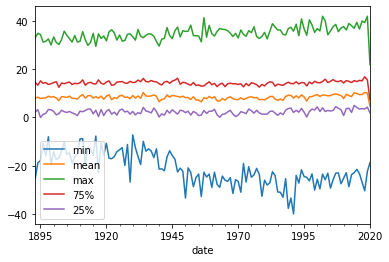

In [18]:
summary_all["temperature"][["min", "mean", "max", "75%", "25%"]].plot()

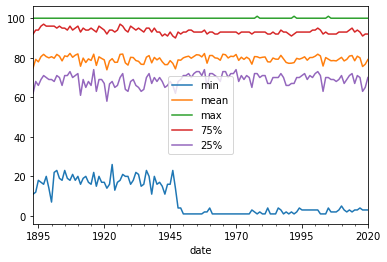

In [19]:
summary_all["humidity"][["min", "mean", "max", "75%", "25%"]].plot()